# ANOVA

### Autor

Wiktoria Galarowicz

### Importowanie bibliotek

In [1]:
import pandas as pd
from dfply import *
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, levene

In [2]:
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)

In [3]:
dane = pd.read_excel('Dane.xlsx', sheet_name='dane', index_col = 0)
dane.head()

,czas,wiek pielęgniarki,choroba,grupa
1,20,I,kardiologiczna,1
2,25,I,kardiologiczna,1
3,22,I,kardiologiczna,1
4,27,I,kardiologiczna,1
5,21,I,kardiologiczna,1


In [4]:
list(dane) # nazwy kolumn

['czas ', 'wiek  pielęgniarki', 'choroba', 'grupa']

In [5]:
dane.rename(columns={'czas ': 'czas', 'wiek  pielęgniarki': 'wiek_pielegniarki'}, inplace = True)

In [6]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 1 to 80
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   czas               80 non-null     int64 
 1   wiek_pielegniarki  80 non-null     object
 2   choroba            80 non-null     object
 3   grupa              80 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ KB


Zmienna `czas` jest numeryczna (liczby całkowite), a zmienne `wiek pielęgniarki` i `choroba` są kategorialne.</br> 
Zmienna `grupa` została manualnie utworzona w excelu. </br> 
Nie ma braków danych. Zmienna zależna w analizie to `czas`.

In [7]:
dane['grupa'] = dane['grupa'].astype(object)

Dla zmienne `grupa` konieczna była zmiana typu, ponieważ program zidentyfikował ją jako zmienna numeryczna, a jest to zmienna kategorialna.

In [8]:
dane.dtypes

czas                  int64
wiek_pielegniarki    object
choroba              object
grupa                object
dtype: object

In [9]:
grouped_data = dane.groupby(['choroba', 'wiek_pielegniarki'])

In [10]:
average_by_group = grouped_data['czas'].mean()
print(average_by_group)

choroba         wiek_pielegniarki
gruźlica        I                    20.0
                II                   27.4
                III                  25.6
                IV                   28.8
kardiologiczna  I                    23.0
                II                   28.4
                III                  26.2
                IV                   29.2
nowotworowa     I                    35.2
                II                   30.0
                III                  39.8
                IV                   48.0
udar            I                    33.2
                II                   33.4
                III                  40.2
                IV                   46.4
Name: czas, dtype: float64


### Badanie normalaności

W celu sprawdzenia, czy rozkład jest zbliżony do rozkładu normalnego wykonany zostanie test Shapiro-Wilka, w którym hipotezy są następujące: 
<p style='text-align: center;'> H0: Rozkład badanej zmiennej jest zbliżony do normalnego <br> H1: Rozkład zmiennej nie jest zbliżony do normalnego
</p>

Sprawdzamy normalność rozkładu dla każdej z grup zmiennej objaśniającej.

In [11]:
g = {}
for i in range(1, 17):
    g[i] = dane[dane['grupa'] == i]

In [12]:
for i in range(1, 17):
    p_value = shapiro(g[i] >> select(X.czas)).pvalue
    print(f'P-value dla grupy {i}: {p_value}')

P-value dla grupy 1: 0.5845787525177002
P-value dla grupy 2: 0.24481956660747528
P-value dla grupy 3: 0.1264229267835617
P-value dla grupy 4: 0.3254301846027374
P-value dla grupy 5: 0.1709563434123993
P-value dla grupy 6: 0.3254301846027374
P-value dla grupy 7: 0.25133123993873596
P-value dla grupy 8: 0.6774504780769348
P-value dla grupy 9: 0.20062367618083954
P-value dla grupy 10: 0.38418078422546387
P-value dla grupy 11: 0.6230623722076416
P-value dla grupy 12: 0.42719900608062744
P-value dla grupy 13: 0.898902952671051
P-value dla grupy 14: 0.4924813508987427
P-value dla grupy 15: 0.7314968109130859
P-value dla grupy 16: 0.4211485683917999


Za każdym razem wartość p-value była wyższa niż przyjęty próg istotności a=0,05. Oznacza to, że nie ma podstaw do odrzucenia hipotezy zerowej mówiącej o rozkładzie badanej populacji zbliżonym do normalnego.

### Homogeniczność wariancji w próbach

Do zbadania jednorodności wariancji w próbach wykorzystane zostaną dwa testy: Levene’a oraz Bartletta.
<p style='text-align: center;'> H0: Rozkłady mają jednakowe wariancje (homogeniczność wariancji) <br> H1: Rozkłady nie mają jednakowych wariancji (heterogeniczność wariancji)
</p>

In [13]:
gru = [g[i]['czas'] for i in range(1, 17)]

stat, p = levene(*gru, center = 'mean')
print('Test Levene\'a:')
print('Wartość statystyki testu:', stat)
print('P-value:', p)

Test Levene'a:
Wartość statystyki testu: 2.57708759024656
P-value: 0.004504726903037861


Na podstawie testu Levene'a należy odrzucić hipotezę zerową na rzecz hipotezy alternatywnej. Rozkłady nie mają jednakowej wariancji. </br>
Zdecydowana się na wykonanie testu Brown'a Forsythe'a o takich samych hipotezach.

In [14]:
gru = [g[i]['czas'] for i in range(1, 17)]

stat, p = levene(*gru, center = 'median') 
print("Test Brown'a Forsythe'a:")
print('Wartość statystyki testu:', stat)
print('P-value:', p)

Test Brown'a Forsythe'a:
Wartość statystyki testu: 1.2604927782497877
P-value: 0.25341566364196844


Nie ma podstaw do odrzucenia hipotezy zerowej, czyli nie ma istotnych różnic w wariancji pomiędzy grupami.

### ANOVA dwukierunkowa

<p style='text-align: center;'> 
    H0a: Średni czas pracy poświęcony na indywidualne wizyty domowe jest taki sam w każdej grupie wiekowej pielęgniarek<br> <br>
    H0b: Średni czas pracy poświęcony na indywidualne wizyty domowe jest taki sam w każdej z grup chorób <br> <br>
    H0c: Nie ma interakcji pomiędzy grupą wiekową pielęgniarki a chorobą badanych osób mającą wpływ na czas poświęcony na indywidualne wizyty domowe
</p>

<Figure size 640x480 with 0 Axes>

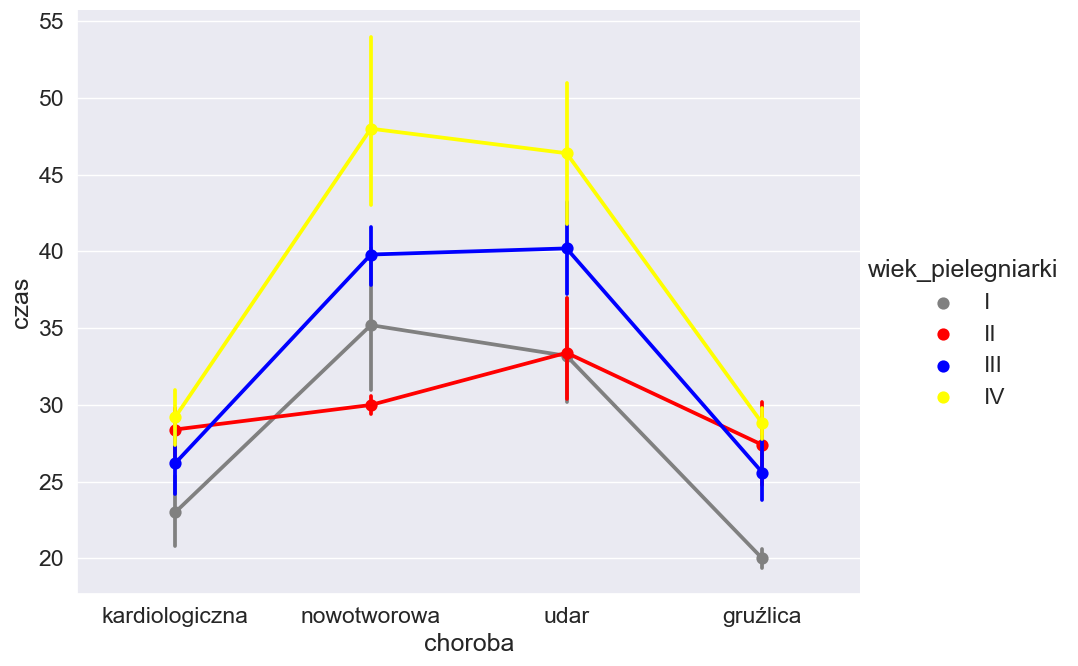

In [15]:
plt.clf()
colo = ['gray', 'red', 'blue', 'yellow']

sns.set(font_scale=1.5)
sns.factorplot(x='choroba',
            y = 'czas', 
            hue='wiek_pielegniarki',
            data=dane, 
            palette=colo, 
            height=7,
            aspect=1.3)

plt.show()

In [16]:
model = ols(
    'czas ~ C(wiek_pielegniarki) + C(choroba) +\
    C(wiek_pielegniarki):C(choroba)', data=dane).fit()
anova = sm.stats.anova_lm(model, typ=2)
anova
anova.style.format('{:.5f}')

,sum_sq,df,F,PR(>F)
C(wiek_pielegniarki),1201.05000,3.00000,27.26948,0.00000
C(choroba),2992.45000,3.00000,67.94267,0.00000
C(wiek_pielegniarki):C(choroba),608.45000,9.00000,4.60489,0.00010
Residual,939.60000,64.00000,nan,nan


Odrzucamy hipotezę H0a: Istnieją znaczące różnice pomiędzy grupami wiekowymi pielęgniarek (F = 27,27, p=0,0000000000176, p <0,01).</br></br>
Odrzucamy hipotezę H0b: Istnieją znaczące różnice pomiędzy grupami chorób (F = 67,94, p=0,000000000000000000072, p <0,01).</br></br>
Odrzucamy hipotezę H0c: Jest efekt interakcji (F = 4,6, p=0,00010).